# 0. Instructions

**Follow the universal workflow of DLWP 4.5 (1st edition) for a problem and dataset of your choice**.

You can use the tensorflow datasets, MNIST, Reuters, IMDB and Boston Housing Price, or an external dataset. Work exclusively in this Jupyter notebook.

**You can only use DLWP Part 1 layers (Chapters 1-4) i.e. restrict your models to tensorflow sequential Dense and Dropout layers**.

A text cell and sometimes a code cell follows each section heading. These cells are for your response to the section title. The text that you add in these cells form the major component of the awarded grade. The aim is to use the section headings to construct a formal project report. What you did, and why, and what was the outcome: explanations, interpretations, evaluations and conclusions. You can add cells; above all, you must prepare a well-structured and readable document.

You can use as much DLWP code and code from the video notebooks as you wish but you must reference all code that is not original.

Export this Jupyter notebook to html and submit. Do not submit this notebook or any data files. Submit only the html export of this notebook.

(For Colab users: Colab does not have an html facility. Either:
Download the colab notebook and load into Jupyter; you will then be able to export as html
or

Follow the instructions in this blog https://python.plainenglish.io/how-to-convert-google-colab-notebook-ipynb-to-html-ccfeda199246 i.e. download from colab and then reload into colab's session storage. Then run the script
%%shelljupyter nbconvert --to html /Your notebook path/file.ipynb
and download the html version.)


# 1. Problem definition and dataset

Sentiment analysis is a subfield of Natural Language Processing (NLP) that focuses on identifying and extracting subjective information from text data. It is widely used in various domains such as social media monitoring, marketing to analyze customer reviews, and the entertainment industry to gauge viewers sentiment towards content and guide filmakers into making better movies and TV shows.

The ability to automatically classify text as expressing a positive or negative sentiment is a fundamental task in sentiment analysis.

In this exercise I aim to use the IMDB dataset to tackle the problem of sentiment classification, the goal is to develop a model that can accurately classify the sentiment of movie reviews.

The dataset consist of 50,000 movie reviews labeled as either positive or negative.

# 2. Success metric(s)

As this is a binary classification problem (positive vs negative sentiment), I'm going to be using the following metrics to measure success of the model:

* Accuracy gives me the ratio of correctly predicted instances (both positive and negative) to the tostal instances. Gives a general sense of how often the model is correct.

Defined as:
$Accuracy = \frac{True Positives + True Negatives}{Total Number of Samples}$


* Precision: The ratio of correctly predicted positive instances to the total predicted positive. Measures the accuracy of the positive predictions. This is important 

Defined as:
$Precision = \frac{True Positives}{True Positives + False Positives}$



# 3. Evaluation protocol

For my evaluation protocol I'll be maintaing a hold-out validation set. Meaning I'll be splitting the data set into three distinct subsets:
* Training Set: Used to train the model
* Validation Set: Used to fine-tune the model's hyperparameters and prevent overfitting
* Test Set: Used to assess the final performance of the model on new unseen data.

Reasoning for choosing this method:
* Prevents Data Leakage: This method ensures that the validation and test data are kept completely separate from the training data. This separation prevents data leakage, where information from the test set might inadvertently influence the model, leading to overly optimistic performance estimates.
* Effective for large datasets: When a large amount of data is available, the hold-out mehitd is effective as it allows sufcfient data for both training the model and evaluating it.
* Addresses Time Dependency in a Time Series Dataset: By partitioning the data chronologically, we ensure that the model is trained on past data and evaluated on future data, which reflects the real-world scenario where predictions are made for future time points based on historical observations.

# 4. Data preparation

The IMDB dataset from keras is provided with already splitted datasets, one for training and one for testing holding 25k reviews each. The reviews are already pre-processed by turning the words into sequences of integers.

A dictionary is provided to convert these back into their original form if needed, let's do this for inspecting the data for a moment.

In [9]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
word_index = imdb.get_word_index()


def decode_review(dictionary, review):
    reverse_index = {}
    for word, index in dictionary.items():
        reverse_index[index] = word
    
    decoded_review = []
    for word_index in review:
        decoded_review.append(reverse_index.get(word_index - 3, '?'))
    
    return ' '.join(decoded_review)

print(decode_review(word_index, train_data[0]))

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

We can't feed these list of integers into a neural network, so we need to transform it into something we can use as an input. As we can only use Dense layers I'm going to one-hot encode the lists to turm them into vectors of 0s and 1s, if not word embeddings could be a better option for this as they capture the semantic relationship in between words which can improve generalization.

In [10]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# 5. Gaining statistical power

With the dataset ready, I'm going to build a very basic model that should beat a baseline accuracy of 0.5. As this dataset is balanced with 50% positive and 50% negative reviews if I were to guess the sentiment of each review randomly I would be correct hald the time. Therefore a naive model with no learning would achieve a baseline accuracy of 50%.

For this basic model I will use a single input layer and one hidden layer with 16 neurons for both, with an output layer with 1 neuron using the `sigmoid` activation algorithm..

I'm going to use the `rmsprop` optimizer and the `binary_crossentropy` loss function as a starting point. The model will be initially trained for 20 epochs.

In [11]:
from keras import models, layers

baseline_model = models.Sequential()
baseline_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
baseline_model.add(layers.Dense(16, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

baseline_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

baseline_history = baseline_model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

/home/esgarcia/uol_workspace/machine-learning/final/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7240 - loss: 0.5906 - val_accuracy: 0.8662 - val_loss: 0.3966
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8870 - loss: 0.3440 - val_accuracy: 0.8730 - val_loss: 0.3255
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9207 - loss: 0.2528 - val_accuracy: 0.8837 - val_loss: 0.2920
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9334 - loss: 0.1994 - val_accuracy: 0.8867 - val_loss: 0.2790
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9449 - loss: 0.1678 - val_accuracy: 0.8854 - val_loss: 0.2818
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9579 - loss: 0.1395 - val_accuracy: 0.8855 - val_loss: 0.2861
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9613 - loss: 0.1218 - val_accuracy: 0.8843 - val_loss: 0.2961
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9736 - loss: 0.0960 - val_accuracy: 0.8806 - val_loss

Now with the model train let's compare the training and validation the loss and accuracy of the model.

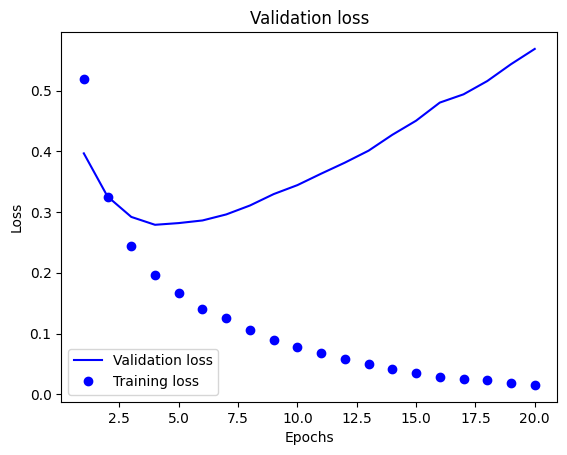

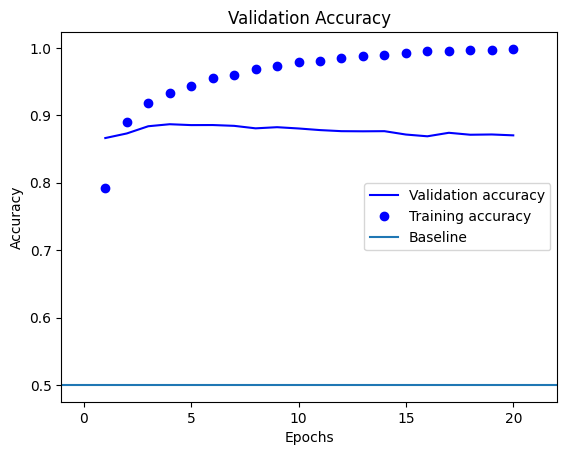

In [12]:
import matplotlib.pyplot as plt

baseline_loss = baseline_history.history['loss']
baseline_val_loss = baseline_history.history['val_loss']
baseline_accuracy = baseline_history.history['accuracy']
baseline_val_accuracy = baseline_history.history['val_accuracy']

epochs = range(1, len(baseline_loss) + 1)

plt.plot(epochs, baseline_val_loss, 'b', label="Validation loss")
plt.plot(epochs, baseline_loss, 'bo', label="Training loss")
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, baseline_val_accuracy, 'b', label="Validation accuracy")
plt.plot(epochs, baseline_accuracy, 'bo', label="Training accuracy")
plt.axline((0, 0.50), (len(baseline_loss)+1, 0.50), label="Baseline")
plt.title("Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The basic model beats the baseline hence achieving statistical power, also the upwards trend of the validation loss and downard trend of the validation accuracy could be pointing at an overfitting model that peaks at around epoch 4 or 5.

# 6. Scaling up

In this section I'm going to be attempting to answer the question "Is my model sufficently powerful?", my previous model was slightly overfitting as it probably doesn't have enough capacity to adjust itself to the dataset.

I'm going to start by adding an additional hidden layer to the model and comparing its performance against my baseline.

In [13]:
histories = []

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

histories.append(model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val)))


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6608 - loss: 0.6215 - val_accuracy: 0.8527 - val_loss: 0.4181
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8852 - loss: 0.3612 - val_accuracy: 0.8706 - val_loss: 0.3416
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9182 - loss: 0.2505 - val_accuracy: 0.8558 - val_loss: 0.3486
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9323 - loss: 0.2021 - val_accuracy: 0.8835 - val_loss: 0.2888
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9503 - loss: 0.1639 - val_accuracy: 0.8908 - val_loss: 0.2751
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9543 - loss: 0.1417 - val_accuracy: 0.8774 - val_loss: 0.3151
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9637 - loss: 0.1204 - val_accuracy: 0.8784 - val_loss: 0.3197
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9730 - loss: 0.1020 - val_accuracy: 0.8787 - val_loss

In [15]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

histories.append(model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=1024, validation_data=(x_val, y_val)))

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6034 - loss: 0.6498 - val_accuracy: 0.8306 - val_loss: 0.4670
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8425 - loss: 0.4240 - val_accuracy: 0.8017 - val_loss: 0.4374
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8607 - loss: 0.3471 - val_accuracy: 0.8682 - val_loss: 0.3322
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9034 - loss: 0.2650 - val_accuracy: 0.8750 - val_loss: 0.3075
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9219 - loss: 0.2264 - val_accuracy: 0.8794 - val_loss: 0.3042
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9321 - loss: 0.1987 - val_accuracy: 0.8819 - val_loss: 0.2913
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9392 - loss: 0.1725 - val_accuracy: 0.8859 - val_loss: 0.2843
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9531 - loss: 0.1438 - val_accuracy: 0.8873 - v

In [28]:
def random_color():
    r = int(np.random.rand(0, 255))
    b = int(np.random.rand(0, 255))
    g = int(np.random.rand(0, 255))
    return (r, g, b)

for i, history in enumerate(histories):
    val_loss = history.history['val_loss']

    plt.plot(epochs, val_loss, label=f"Validation loss {i}", color=np.random.rand(3,))
    plt.title("Validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

plt.legend()
plt.show()

for i, history in enumerate(histories):
    val_accuracy = history.history['val_accuracy']

    plt.plot(epochs, val_accuracy, label=f"Validation accuracy {i}", color=np.random.rand(3,))
    plt.title("Validation accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

plt.legend()
plt.show()

TypeError: only length-1 arrays can be converted to Python scalars

# 7. Regularisation and tuning

Response

In [ ]:
# code

# 8. Evaluation

Response

In [ ]:
# code

# 9. Conclusion

Response

In [ ]:
# code